# NeuroData Design: Sprint 1, Week 8
### Patrick Myers, Wednesday Oct 23


In [101]:
#Import the data from a Drive folder
import sys
import glob
import pandas as pd
import numpy as np
import subprocess
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches



filelist = []
file_list = glob.glob('../edgelists/*')
for f in file_list:
    file = open(f, 'r')
    filelist.append(file.read())

    
file_list = [f.replace("../edgelists\\", "") for f in file_list if "sub-" in f]
#file_list = [f.replace("sub-", "").replace("_acq-64dir_dwi_JHU.edgelist", "") for f in file_list if "sub-" in f]

 
sub_names = list()
for f in file_list:
    f = f.replace("sub-", "").replace("_acq-64dir_dwi_JHU.edgelist", "")
    sub_names.append(f)




In [105]:
#Define Vivek's functions to calculate eigenvalues of laplacian
import numpy as np

import subprocess
import requests

# Data structure
import networkx as nx
from networkx import normalized_laplacian_matrix


def _calculate_eigenvalues(G):
    # Return eigenvalues of the Laplacian
    L = normalized_laplacian_matrix(G)
    e = list(np.linalg.eigvals(L.A))
    return e
  
def feature_select(edgelists, files):
    
    # Get generator
    #edgelists = graph_collector.convert_edgelist_all()

    # Calculate eigenvalues for each graph
    eigvals = [_calculate_eigenvalues(G[0]) for G in edgelists]
    filelist = [_calculate_eigenvalues(G[1]) for G in edgelists]
    len_eig = [len(row) for row in eigvals]
    cutoff = len_eig[np.argmax(np.bincount(len_eig))]
    # Preserve only the necessary features
    X = []
    included_files = []
    count = 0
    for row in eigvals:
        if len(row) >= cutoff:
            X.append(row[-cutoff:])
            included_files.append(files[count])
        count = count + 1

    return X, included_files
  
def convert_edgelist(filename, file_name, draw_graph=False):

        # Fetch edgelist
        edges = filename.split()
        edges = [int(x) for x in edges]
        edges = [tuple(edges[x:x + 3]) for x in range(0, len(edges), 3)]


        if edges == []:
            print('' + ' is empty.')
            return

        # Convert edgelist to networkx object
        G = nx.Graph()
        G.add_weighted_edges_from(edges)

        if draw_graph:
            nx.draw(G)
            plt.show()

        return G, file_name

def convert_edgelist_all(filelist, file_list):
        # returns a generator of all filelists
        for fn in range(0,len(filelist)):
            G = convert_edgelist(filelist[fn], file_list[fn])
            if G is not None:
                yield G

In [106]:
def khop_locality(G, filename):

    subject_id = filename.split('_')[0].split('-')[1]
    embed = [subject_id]

    for node in G.nodes:

        one_hop = list(nx.single_source_shortest_path_length(G, node, cutoff=1).keys())
        two_hop = list(nx.single_source_shortest_path_length(G, node, cutoff=2).keys())

        embed += len(G.subgraph(one_hop).edges()), len(G.subgraph(two_hop).edges())

    if len(embed) == 97:
        return embed

In [107]:
#Perform PCA to get the first and second principal components
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt



edgelists = convert_edgelist_all(filelist, file_list)
files = []
for G in edgelists:
  files.append(G[1])
edgelists = convert_edgelist_all(filelist, file_list)
#data = feature_select(edgelists, files)
M = []
included_files = []
count = 0
for f in filelist:
    try:
        G, filename = convert_edgelist(f, file_list[count])
    except TypeError:
        print('Type Error')
    if G is not None:
        embed = khop_locality(G, file_list[count])
    if embed is not None:
        M.append(embed)
        included_files.append(file_list[count])
    count = count + 1
    

tags = []
for t in included_files:
    t = t.replace("sub-", "").replace("_acq-64dir_dwi_JHU.edgelist", "")
    tags.append(t)
X = M
X = np.asarray(X)


 is empty.
 is empty.
Type Error


In [108]:
Xnew = X[:,1:]

Xnew = Xnew.astype(dtype=int)
type(Xnew[1,1])

numpy.int32

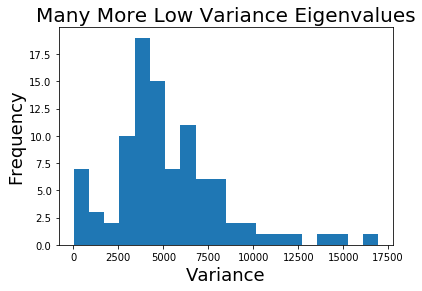

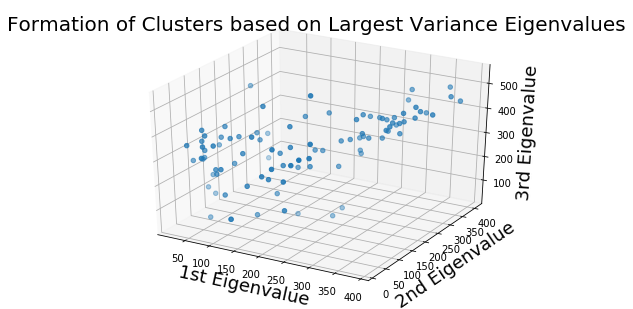

In [110]:
#Pick the top three variance features from eigenvalue matrix
from sklearn.feature_selection import VarianceThreshold
from scipy import ndimage
from mpl_toolkits.mplot3d import Axes3D

var = []
for i in range(0,Xnew.shape[1]):
    var.append(ndimage.variance(Xnew[:,i]))
var = np.asarray(var)
plt.hist(var, 20)
plt.title('Many More Low Variance Eigenvalues', fontsize = 20)
plt.xlabel('Variance', fontsize=18)
plt.ylabel('Frequency', fontsize = 18)
plt.show()

rem = VarianceThreshold(threshold=10000)
reduced = rem.fit_transform(Xnew)
reduced.shape


#Plot data on these  features
fig = plt.figure(facecolor = 'w')
ax = Axes3D(fig)
ax.scatter(reduced[:,0],reduced[:,1],reduced[:,2]);
plt.xlabel('1st Eigenvalue', fontsize=18)
plt.ylabel('2nd Eigenvalue', fontsize=18)
ax.set_zlabel('3rd Eigenvalue', fontsize=18)
ax.set_facecolor('white')
fig.suptitle('Formation of Clusters based on Largest Variance Eigenvalues', fontsize=20)
plt.show()

(100, 3)


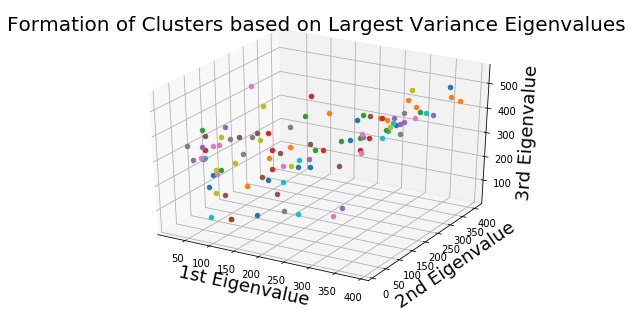

In [111]:
import pandas as pd
import numpy as np
import difflib


diagnoses = pd.read_csv('../processed/Diagnoses.csv')
print(diagnoses.shape)


for i in range(0, 100):
  diagnoses.iloc[i,0] = diagnoses.iloc[i,0].rstrip()

for i in range(0,97):
  tags[i] = tags[i].rstrip()

sub_names = list()
for f in file_list:
    f = f.replace("sub-", "").replace("_acq-64dir_dwi_JHU.edgelist", "")
    sub_names.append(f)


labels = np.zeros((98,3), dtype=object)
for i in range(0,98):
    labels[i,0] = sub_names[i]
    labels[i,1] = tags[i]
    labels[i,2] = str(sub_names[i] == tags[i])
label_check = pd.DataFrame(data = labels, columns = ['Labels in Plot', 'Actual Labels', 'Same'])
label_check.to_csv('../processed/label_check.csv')


fig = plt.figure(facecolor = 'w')
ax = Axes3D(fig)
plt.xlabel('1st Eigenvalue', fontsize=18)
plt.ylabel('2nd Eigenvalue', fontsize=18)
ax.set_zlabel('3rd Eigenvalue', fontsize=18)
fig.suptitle('Formation of Clusters based on Largest Variance Eigenvalues', fontsize=20)
for x in range(0, len(tags)):
  for i in range(0, diagnoses.shape[0]):
    if tags[x] == diagnoses.iloc[i,0]:
      if diagnoses.iloc[i,1] == 'No Diagnosis Given' or diagnoses.iloc[i,1] == 'No Diagnosis Given: Incomplete Eval':
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='k');
      elif diagnoses.iloc[i,1] == 'Neurodevelopmental Disorders':
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='r');
      elif diagnoses.iloc[i,1] == 'Depressive Disorders':
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='b');
      elif diagnoses.iloc[i,1] == 'Anxiety Disorders':
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='y');
      elif diagnoses.iloc[i,1] == 'Bipolar and Related Disorders':
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='g');
      elif diagnoses.iloc[i,1] == 'Disruptive, Impulse Control and Conduct Disorders':
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='c');
      else:
        ax.scatter(reduced[x,0],reduced[x,1],reduced[x,2]);#, c='p');
        

plt.show()